In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time 
import time
import warnings
from collections import deque
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = ['OOK','4ASK','8ASK','BPSK', 
                      'QPSK', '8PSK', '16QAM',
                     '64QAM','OQPSK'
                     ]
#TARGET_MODULATIONS = ['OOK','4ASK','BPSK', 'QPSK', '8PSK','16QAM','GMSK']
BATCH_SIZE = 512 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 300 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = len(TARGET_MODULATIONS) # adjust this to 

patience = 25
# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.3)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 512
  Epochs: 300


In [4]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.7, # training 70 %
                  valid_proportion=0.3, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [5]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
       
        num_mods = len(self.target_modulations)   
        num_snrs = 26         
        
        train_proportion = (num_mods * num_snrs * nf_train) / self.X.shape[0]
        valid_proportion = (num_mods * num_snrs * nf_valid) / self.X.shape[0]
        test_proportion  = (num_mods * num_snrs * nf_test ) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        # print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [0, 1]]
        # print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")

        import math
        
        L = signal_length
        H = int(math.floor(math.sqrt(L)))
        while L % H != 0:
            H -= 1
        W = L // H
        
        self.H, self.W = H, W
        print(f"🔧 Signals will be reshaped to ({H}, {W}) for sequence length {L}")
        print(f"✅ Aspect ratio: {W/H:.2f}, Total elements preserved: {H*W} = {L}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= self.num_data:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_data}")

        x_raw = self.X_data[idx]       # shape: (L, 2)
        y     = int(self.Y_data[idx])
        z     = float(self.Z_data[idx])

        # Convert to tensor
        x = torch.from_numpy(x_raw).float().transpose(0, 1)  # shape: (2, L)

        if self.use_fft:
            # Option 1: FFT from magnitude and phase 2D matrix 
            # Combine to complex signal
            complex_sig = torch.complex(x[0], x[1])
            fft_res = torch.fft.fft(complex_sig)  # shape: (L,) 
            magnitude = torch.abs(fft_res)  # shape: (L,)
            phase = torch.angle(fft_res)  # shape: (L,)

            x_mag2d = magnitude.view(1, self.H, self.W)  # shape: (1, H, W)
            x_phase2d = phase.view(1, self.H, self.W)  # shape: (1, H, W) 

            return x_mag2d, x_phase2d, y, z 

            # option 2: FFT from complex signal to 2D matrix

            # complex_sig = torch.complex(x[0], x[1])  # shape: (L,)
            # fft_res     = torch.fft.fft(complex_sig)  # shape: (L,)
            # x_fft = torch.stack([torch.real(fft_res), torch.imag(fft_res)], dim=1)  # shape: (L, 2)

            # x_real_2d = x_fft[:, 0].view(1, self.H, self.W)  # shape: (1, H, W)
            # x_imag_2d = x_fft[:, 1].view(1, self.H, self.W)  # shape: (1, H, W)

            # return x_real_2d, x_imag_2d, y, z
        

        else:
            # Non-FFT path (amplitude/phase domain)
            i_signal = x[0]  # shape: (L,)
            q_signal = x[1]

            amplitude = torch.sqrt(i_signal**2 + q_signal**2)
            phase     = torch.atan2(q_signal, i_signal)

            i_2d = amplitude.view(1, self.H, self.W)
            q_2d = phase.view(1, self.H, self.W)

            return i_2d, q_2d, y, z

    def get_signal_stats(self):
        """Compute basic stats over a sample of signals."""
        sample_indices = np.random.choice(self.num_data, min(1000, self.num_data), replace=False)
        i_vals, q_vals = [], []
        for idx in sample_indices:
            i2d, q2d, _, _ = self[idx]
            i_vals.append(i2d.flatten())
            q_vals.append(q2d.flatten())
        i_all = torch.cat(i_vals)
        q_all = torch.cat(q_vals)
        return {
            'i_mean': i_all.mean().item(),
            'i_std':  i_all.std().item(),
            'q_mean': q_all.mean().item(),
            'q_std':  q_all.std().item(),
            'shape':  (1, self.H, self.W),
            'num_samples': self.num_data
        }

    def close(self):
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()

    def __del__(self):
        self.close()

In [6]:
# Model 1: Standard CNN-LSTM
try:
    from models.CNN_LSTM_IQ import create_enhanced_CNNLSTMIQModel
    model_standard = create_enhanced_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.6).to(device)
    print("✅ Successfully built Standard CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Standard Model: {e}")

# Model 2: Parallel CNN-LSTM
try:
    from models.CNN_LSTM_Parallel2 import create_diagram_iq_model
    model_parallel = create_diagram_iq_model(n_labels=NUM_CLASSES, dropout_rate=0.6).to(device)
    print("✅ Successfully built Parallel CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Parallel Model: {e}")

✅ Successfully built Standard CNN-LSTM Model
✅ Successfully built Parallel CNN-LSTM Model


In [7]:
from torchinfo import summary 
summary(model_standard) 

Layer (type:depth-idx)                   Param #
CNNLSTMIQModel                           --
├─CNNLSTMBranch: 1-1                     --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─Conv2d: 2-3                       36,928
│    └─BatchNorm2d: 2-4                  128
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─Conv2d: 2-7                       147,584
│    └─BatchNorm2d: 2-8                  256
│    └─MaxPool2d: 2-9                    --
│    └─LeakyReLU: 2-10                   --
│    └─Dropout2d: 2-11                   --
│    └─LSTM: 2-12                        92,000
│    └─LSTM: 2-13                        30,400
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      51
│    └─AdaptiveAvgPool2d: 2-16           --
├─CNNLSTMBranch: 1-2                     --
│    └─Conv2d: 2-17                      640
│    └─BatchNorm2d: 2-18                 128

In [8]:
summary(model_parallel) 

Layer (type:depth-idx)                   Param #
DiagramIQModel                           --
├─DiagramModel: 1-1                      --
│    └─CNN_1: 2-1                        --
│    │    └─Conv2d: 3-1                  640
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  73,856
│    │    └─BatchNorm2d: 3-4             256
│    │    └─MaxPool2d: 3-5               --
│    │    └─LeakyReLU: 3-6               --
│    │    └─Dropout2d: 3-7               --
│    │    └─AdaptiveAvgPool2d: 3-8       --
│    └─CNN_2: 2-2                        --
│    │    └─Conv2d: 3-9                  640
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 73,856
│    │    └─BatchNorm2d: 3-12            256
│    │    └─MaxPool2d: 3-13              --
│    │    └─Conv2d: 3-14                 295,168
│    │    └─BatchNorm2d: 3-15            512
│    │    └─Conv2d: 3-16                 590,080
│    │    └─BatchNorm2d: 3-17            512
│

In [9]:
# Optimizers for both models
optimizer_standard = optim.AdamW(
    model_standard.parameters(), 
    lr=0.002,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

optimizer_parallel = optim.AdamW(
    model_parallel.parameters(), 
    lr=0.002,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Schedulers for both models
scheduler_standard = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_standard, T_0=20, T_mult=2, eta_min=1e-6
)

scheduler_parallel = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_parallel, T_0=20, T_mult=2, eta_min=1e-6
)

# Scalers for mixed precision
scaler_standard = GradScaler()
scaler_parallel = GradScaler()


In [10]:
# Count parameters for both models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

standard_params = count_parameters(model_standard)
parallel_params = count_parameters(model_parallel)

In [11]:
# Shared training components
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizers for both models
optimizer_standard = optim.AdamW(
    model_standard.parameters(), 
    lr=0.002,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

optimizer_parallel = optim.AdamW(
    model_parallel.parameters(), 
    lr=0.002,
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Schedulers for both models
scheduler_standard = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_standard, T_0=20, T_mult=2, eta_min=1e-6
)

scheduler_parallel = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_parallel, T_0=20, T_mult=2, eta_min=1e-6
)

# Scalers for mixed precision
scaler_standard = GradScaler()

In [12]:
# --- Data Loaders ---
print("\n📂 Loading datasets...")
train_dataset = RadioMLIQDataset('train', use_fft=True)
valid_dataset = RadioMLIQDataset('valid', use_fft=True)
test_dataset = RadioMLIQDataset('test', use_fft=True)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}") 


📂 Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset train: 31356 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset valid: 13338 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
Dataset configured to use FFT as input
RadioMLIQDataset test: 913770 samples, 9 classes, 26 SNR levels
Train dataset size: 31356
Validation dataset size: 13338
Test dataset size: 913770


In [13]:
# --- Training Metrics Storage ---
metrics = {
    'standard': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    },
    'parallel': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    }
}

In [14]:
# Early stopping
patience_counters = {'standard': 0, 'parallel': 0}
best_models = {'standard': None, 'parallel': None}

In [15]:
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Train one epoch and return metrics"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for i_inputs, q_inputs, labels, _ in train_loader:
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(i_inputs, q_inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, epoch_time

def validate_epoch(model, valid_loader, criterion, device):
    """Validate one epoch and return metrics"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in valid_loader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, predictions, true_labels

def test_epoch(model, test_loader, criterion, device):
    """Test one epoch and return metrics"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in test_loader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy()) 
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = 100. * correct / total

    return epoch_loss, epoch_accuracy, predictions, true_labels 

In [16]:
# --- Training Loop ---
import copy
import time 
print("\n🎯 Starting comparative training...")
print("=" * 80)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    epoch_start = time.time()
    
    # Train both models
    train_loss_std, train_acc_std, train_time_std = train_epoch(
        model_standard, train_loader, optimizer_standard, criterion, scaler_standard, device
    )
    
    train_loss_par, train_acc_par, train_time_par = train_epoch(
        model_parallel, train_loader, optimizer_parallel, criterion, scaler_parallel, device
    )
    
    # Validate both models
    valid_loss_std, valid_acc_std, pred_std, true_std = validate_epoch(
        model_standard, valid_loader, criterion, device
    )
    
    valid_loss_par, valid_acc_par, pred_par, true_par = validate_epoch(
        model_parallel, valid_loader, criterion, device
    )
    
    # Update metrics
    metrics['standard']['train_losses'].append(train_loss_std)
    metrics['standard']['train_accuracies'].append(train_acc_std)
    metrics['standard']['valid_losses'].append(valid_loss_std)
    metrics['standard']['valid_accuracies'].append(valid_acc_std)
    metrics['standard']['training_times'].append(train_time_std)
    
    metrics['parallel']['train_losses'].append(train_loss_par)
    metrics['parallel']['train_accuracies'].append(train_acc_par)
    metrics['parallel']['valid_losses'].append(valid_loss_par)
    metrics['parallel']['valid_accuracies'].append(valid_acc_par)
    metrics['parallel']['training_times'].append(train_time_par)
    
    # Update schedulers
    scheduler_standard.step()
    scheduler_parallel.step()
    
    # Check for best models and early stopping
    if valid_acc_std > metrics['standard']['best_accuracy']:
        metrics['standard']['best_accuracy'] = valid_acc_std
        metrics['standard']['final_predictions'] = pred_std.cpu().numpy() if hasattr(pred_std, 'cpu') else pred_std
        metrics['standard']['final_true_labels'] = true_std.cpu().numpy() if hasattr(true_std, 'cpu') else true_std
        best_models['standard'] = copy.deepcopy(model_standard.state_dict())
        patience_counters['standard'] = 0
    else:
        patience_counters['standard'] += 1
    
    if valid_acc_par > metrics['parallel']['best_accuracy']:
        metrics['parallel']['best_accuracy'] = valid_acc_par
        metrics['parallel']['final_predictions'] = pred_par.cpu().numpy() if hasattr(pred_par, 'cpu') else pred_par
        metrics['parallel']['final_true_labels'] = true_par.cpu().numpy() if hasattr(true_par, 'cpu') else true_par
        best_models['parallel'] = copy.deepcopy(model_parallel.state_dict())
        patience_counters['parallel'] = 0
    else:
        patience_counters['parallel'] += 1
    
    # Print epoch results
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
        print(f"Standard  - Train: {train_acc_std:.2f}% | Valid: {valid_acc_std:.2f}% | Time: {train_time_std:.2f}s")
        print(f"Parallel  - Train: {train_acc_par:.2f}% | Valid: {valid_acc_par:.2f}% | Time: {train_time_par:.2f}s")
    
    # Early stopping check - stop when BOTH models haven't improved
    if patience_counters['standard'] >= patience and patience_counters['parallel'] >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} - Both models stopped improving")
        break

print("\n🎉 Training Complete!")
print(f"Standard Model Best Accuracy: {metrics['standard']['best_accuracy']:.2f}%")
print(f"Parallel Model Best Accuracy: {metrics['parallel']['best_accuracy']:.2f}%")

# --- Final Testing on Test Set (if test_loader exists) ---
if 'test_loader' in locals() or 'test_loader' in globals():
    print("\n🔍 Final testing on test set...")
    
    # Load best models
    model_standard.load_state_dict(best_models['standard'])
    model_parallel.load_state_dict(best_models['parallel'])
    
    # Test both models
    test_loss_std, test_acc_std, pred_test_std, true_test_std = validate_epoch(
        model_standard, test_loader, criterion, device
    )
    
    test_loss_par, test_acc_par, pred_test_par, true_test_par = validate_epoch(
        model_parallel, test_loader, criterion, device
    )
    
    # Store test results
    metrics['standard']['test_accuracy'] = test_acc_std
    metrics['standard']['test_loss'] = test_loss_std
    metrics['standard']['test_predictions'] = pred_test_std.cpu().numpy() if hasattr(pred_test_std, 'cpu') else pred_test_std
    metrics['standard']['test_true_labels'] = true_test_std.cpu().numpy() if hasattr(true_test_std, 'cpu') else true_test_std
    
    metrics['parallel']['test_accuracy'] = test_acc_par
    metrics['parallel']['test_loss'] = test_loss_par
    metrics['parallel']['test_predictions'] = pred_test_par.cpu().numpy() if hasattr(pred_test_par, 'cpu') else pred_test_par
    metrics['parallel']['test_true_labels'] = true_test_par.cpu().numpy() if hasattr(true_test_par, 'cpu') else true_test_par
    
    print(f"Standard Model Test Accuracy: {test_acc_std:.2f}%")
    print(f"Parallel Model Test Accuracy: {test_acc_par:.2f}%")
else:
    print("\n⚠️  No test_loader found - skipping final testing")


🎯 Starting comparative training...


Training Progress:   2%|▏         | 5/300 [01:32<1:30:24, 18.39s/it]


Epoch 5/300:
Standard  - Train: 22.73% | Valid: 28.05% | Time: 5.50s
Parallel  - Train: 27.61% | Valid: 30.95% | Time: 9.76s


Training Progress:   3%|▎         | 10/300 [03:03<1:28:30, 18.31s/it]


Epoch 10/300:
Standard  - Train: 28.40% | Valid: 30.09% | Time: 5.46s
Parallel  - Train: 28.74% | Valid: 31.98% | Time: 9.81s


Training Progress:   5%|▌         | 15/300 [05:04<1:54:00, 24.00s/it]


Epoch 15/300:
Standard  - Train: 29.74% | Valid: 31.21% | Time: 8.60s
Parallel  - Train: 29.89% | Valid: 31.89% | Time: 12.94s


Training Progress:   7%|▋         | 20/300 [06:45<1:33:47, 20.10s/it]


Epoch 20/300:
Standard  - Train: 30.18% | Valid: 31.53% | Time: 5.52s
Parallel  - Train: 30.77% | Valid: 32.32% | Time: 9.74s


Training Progress:   8%|▊         | 25/300 [08:17<1:24:48, 18.50s/it]


Epoch 25/300:
Standard  - Train: 29.65% | Valid: 31.35% | Time: 5.44s
Parallel  - Train: 29.65% | Valid: 32.29% | Time: 9.65s


Training Progress:  10%|█         | 30/300 [09:46<1:21:02, 18.01s/it]


Epoch 30/300:
Standard  - Train: 30.69% | Valid: 29.43% | Time: 5.33s
Parallel  - Train: 29.86% | Valid: 31.44% | Time: 9.64s


Training Progress:  12%|█▏        | 35/300 [11:17<1:19:42, 18.05s/it]


Epoch 35/300:
Standard  - Train: 30.88% | Valid: 32.03% | Time: 5.40s
Parallel  - Train: 30.50% | Valid: 32.14% | Time: 9.67s


Training Progress:  13%|█▎        | 40/300 [12:47<1:18:03, 18.01s/it]


Epoch 40/300:
Standard  - Train: 31.13% | Valid: 29.08% | Time: 5.38s
Parallel  - Train: 30.92% | Valid: 32.49% | Time: 9.65s


Training Progress:  15%|█▌        | 45/300 [14:18<1:17:23, 18.21s/it]


Epoch 45/300:
Standard  - Train: 31.48% | Valid: 32.44% | Time: 5.57s
Parallel  - Train: 31.24% | Valid: 32.74% | Time: 9.78s


Training Progress:  17%|█▋        | 50/300 [15:50<1:16:24, 18.34s/it]


Epoch 50/300:
Standard  - Train: 31.82% | Valid: 32.02% | Time: 5.59s
Parallel  - Train: 32.07% | Valid: 32.99% | Time: 9.87s


Training Progress:  18%|█▊        | 55/300 [17:22<1:15:09, 18.41s/it]


Epoch 55/300:
Standard  - Train: 32.16% | Valid: 32.41% | Time: 5.51s
Parallel  - Train: 32.43% | Valid: 33.38% | Time: 9.80s


Training Progress:  20%|██        | 60/300 [18:53<1:13:04, 18.27s/it]


Epoch 60/300:
Standard  - Train: 32.45% | Valid: 32.18% | Time: 5.44s
Parallel  - Train: 32.64% | Valid: 33.15% | Time: 9.81s


Training Progress:  22%|██▏       | 65/300 [20:24<1:11:21, 18.22s/it]


Epoch 65/300:
Standard  - Train: 31.72% | Valid: 32.07% | Time: 5.48s
Parallel  - Train: 31.33% | Valid: 32.40% | Time: 9.77s


Training Progress:  23%|██▎       | 70/300 [21:55<1:09:35, 18.15s/it]


Epoch 70/300:
Standard  - Train: 31.46% | Valid: 31.49% | Time: 5.40s
Parallel  - Train: 31.26% | Valid: 32.40% | Time: 9.68s


Training Progress:  25%|██▌       | 75/300 [23:26<1:08:16, 18.21s/it]


Epoch 75/300:
Standard  - Train: 31.38% | Valid: 31.86% | Time: 5.56s
Parallel  - Train: 32.11% | Valid: 31.85% | Time: 9.74s


Training Progress:  27%|██▋       | 80/300 [24:57<1:06:43, 18.20s/it]


Epoch 80/300:
Standard  - Train: 31.99% | Valid: 31.65% | Time: 5.56s
Parallel  - Train: 31.70% | Valid: 32.76% | Time: 9.73s


Training Progress:  28%|██▊       | 85/300 [26:38<1:09:42, 19.45s/it]


Epoch 85/300:
Standard  - Train: 32.34% | Valid: 31.11% | Time: 5.47s
Parallel  - Train: 32.35% | Valid: 31.37% | Time: 9.72s


Training Progress:  30%|███       | 90/300 [28:32<1:21:34, 23.31s/it]


Epoch 90/300:
Standard  - Train: 32.36% | Valid: 32.12% | Time: 8.67s
Parallel  - Train: 32.38% | Valid: 32.35% | Time: 12.97s


Training Progress:  32%|███▏      | 95/300 [30:03<1:05:07, 19.06s/it]


Epoch 95/300:
Standard  - Train: 32.52% | Valid: 31.80% | Time: 5.43s
Parallel  - Train: 33.01% | Valid: 32.80% | Time: 9.74s


Training Progress:  33%|███▎      | 100/300 [31:34<1:01:08, 18.34s/it]


Epoch 100/300:
Standard  - Train: 32.75% | Valid: 32.24% | Time: 5.46s
Parallel  - Train: 32.85% | Valid: 32.71% | Time: 9.71s


Training Progress:  35%|███▌      | 105/300 [33:05<59:17, 18.25s/it]  


Epoch 105/300:
Standard  - Train: 33.02% | Valid: 32.19% | Time: 5.55s
Parallel  - Train: 33.24% | Valid: 32.90% | Time: 9.74s


Training Progress:  37%|███▋      | 110/300 [34:36<57:41, 18.22s/it]


Epoch 110/300:
Standard  - Train: 32.73% | Valid: 29.41% | Time: 5.57s
Parallel  - Train: 33.20% | Valid: 32.55% | Time: 9.75s


Training Progress:  38%|███▊      | 115/300 [36:37<1:15:20, 24.43s/it]


Epoch 115/300:
Standard  - Train: 33.15% | Valid: 32.23% | Time: 8.64s
Parallel  - Train: 33.70% | Valid: 32.75% | Time: 12.94s


Training Progress:  38%|███▊      | 115/300 [37:02<59:34, 19.32s/it]  


Early stopping at epoch 116 - Both models stopped improving

🎉 Training Complete!
Standard Model Best Accuracy: 32.50%
Parallel Model Best Accuracy: 33.38%

🔍 Final testing on test set...


Standard Model Test Accuracy: 32.15%
Parallel Model Test Accuracy: 32.40%


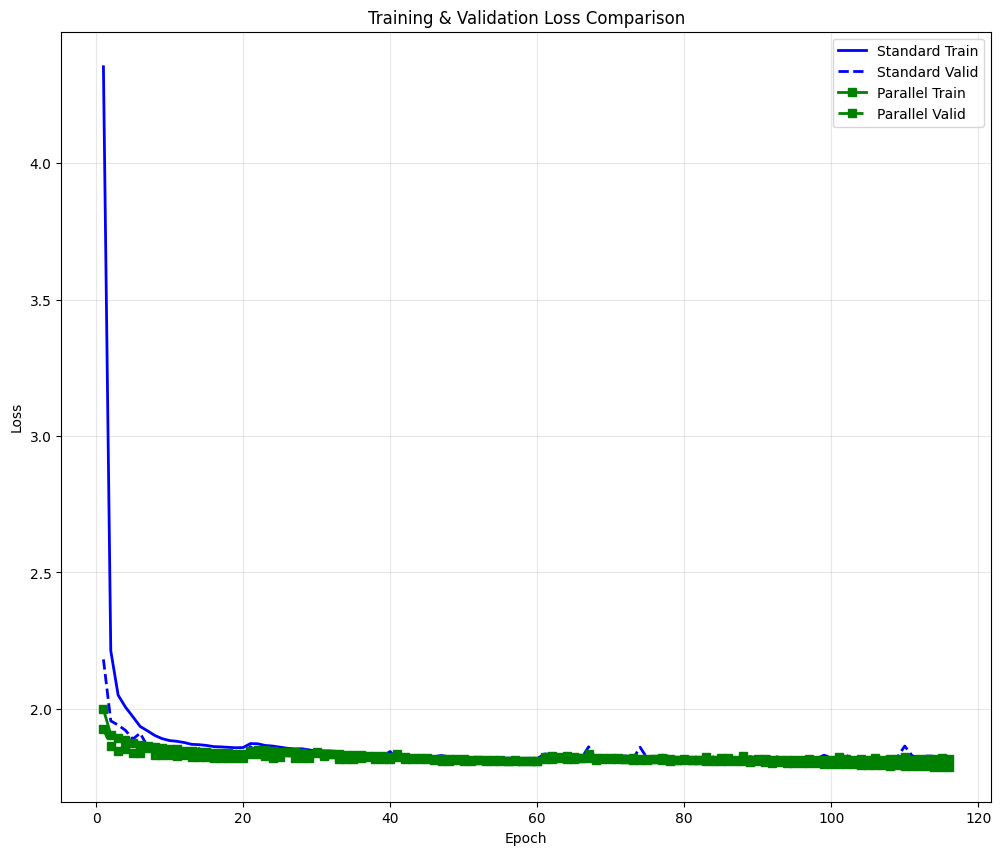

In [17]:
plt.figure(figsize=(12, 10), dpi=100)
epochs = range(1, len(metrics['standard']['train_losses']) + 1)
plt.plot(epochs, metrics['standard']['train_losses'], 'b-', label='Standard Train', linewidth=2)
plt.plot(epochs, metrics['standard']['valid_losses'], 'b--', label='Standard Valid', linewidth=2)
plt.plot(epochs, metrics['parallel']['train_losses'], 'r-', label='Parallel Train', linewidth=2, marker = 's', color = 'green')
plt.plot(epochs, metrics['parallel']['valid_losses'], 'r--', label='Parallel Valid', linewidth=2,marker = 's', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

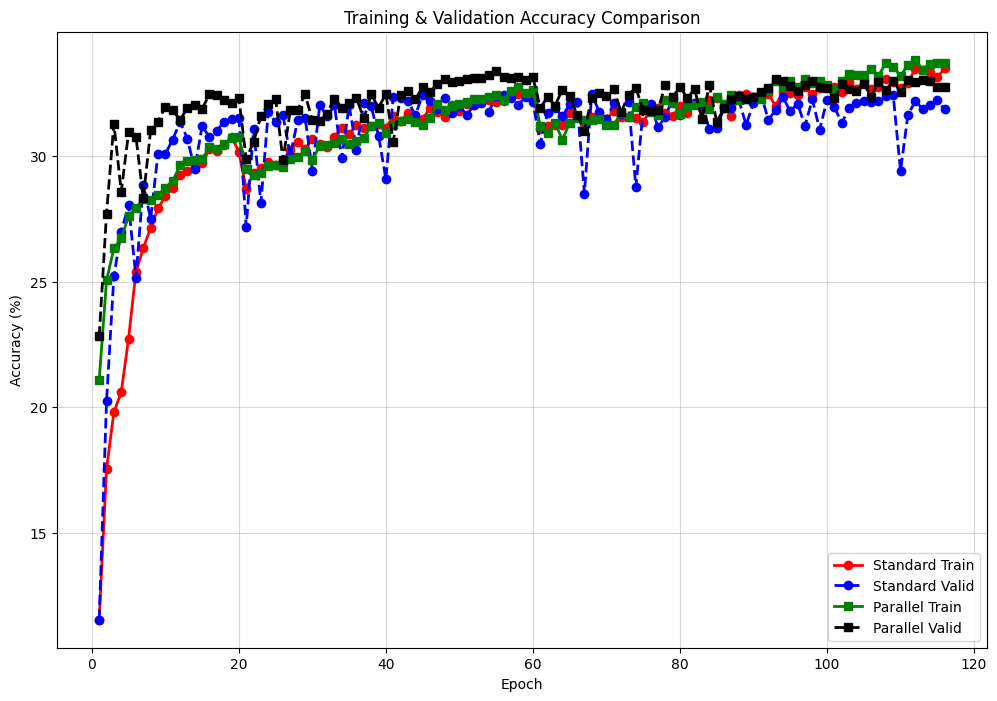

In [18]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(epochs, metrics['standard']['train_accuracies'], 'b-', label='Standard Train', linewidth=2,color = 'red',marker = 'o')
plt.plot(epochs, metrics['standard']['valid_accuracies'], 'b--', label='Standard Valid', linewidth=2,color = 'blue', marker = 'o')
plt.plot(epochs, metrics['parallel']['train_accuracies'], 'r-', label='Parallel Train', linewidth=2,color = 'green', marker = 's')
plt.plot(epochs, metrics['parallel']['valid_accuracies'], 'r--', label='Parallel Valid', linewidth=2, color = 'black', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.5)

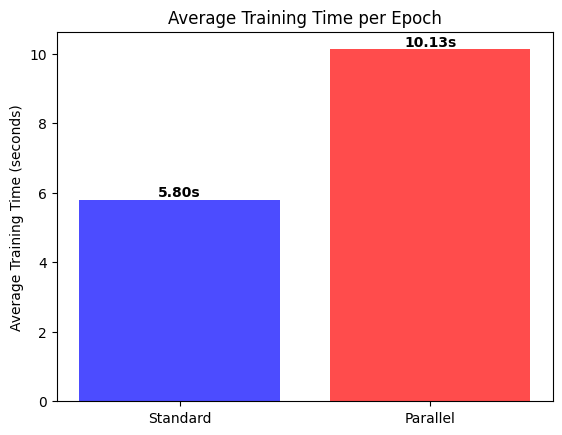

In [19]:
    avg_time_std = np.mean(metrics['standard']['training_times'])
    avg_time_par = np.mean(metrics['parallel']['training_times'])
    models = ['Standard', 'Parallel']
    times = [avg_time_std, avg_time_par]
    colors = ['blue', 'red']
    bars = plt.bar(models, times, color=colors, alpha=0.7)
    plt.ylabel('Average Training Time (seconds)')
    plt.title('Average Training Time per Epoch')
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

Text(0.5, 1.0, 'Model Performance Summary')

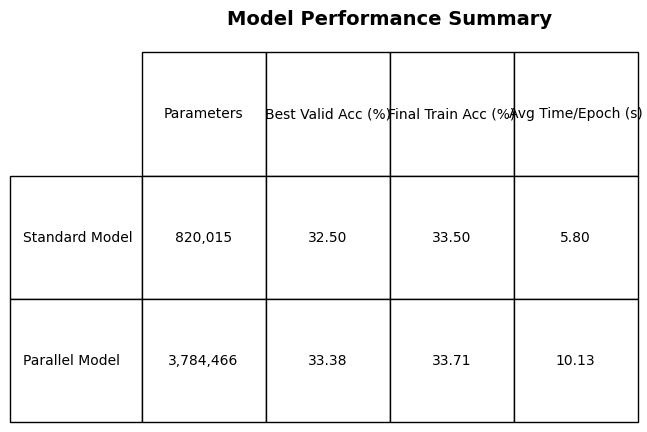

In [20]:
    performance_data = {
        'Metric': ['Parameters', 'Best Valid Acc (%)', 'Final Train Acc (%)', 'Avg Time/Epoch (s)'],
        'Standard': [
            f"{standard_params:,}",
            f"{metrics['standard']['best_accuracy']:.2f}",
            f"{metrics['standard']['train_accuracies'][-1]:.2f}",
            f"{avg_time_std:.2f}"
        ],
        'Parallel': [
            f"{parallel_params:,}",
            f"{metrics['parallel']['best_accuracy']:.2f}",
            f"{metrics['parallel']['train_accuracies'][-1]:.2f}",
            f"{avg_time_par:.2f}"
        ]
    }
    
    # Create table
    plt.axis('off')
    table = plt.table(cellText=[performance_data['Standard'], performance_data['Parallel']],
                     rowLabels=['Standard Model', 'Parallel Model'],
                     colLabels=performance_data['Metric'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Model Performance Summary', pad=20, fontsize=14, fontweight='bold')

Text(50.722222222222214, 0.5, 'Actual')

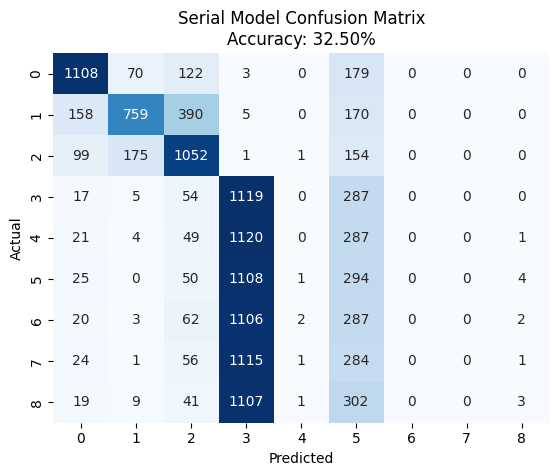

In [21]:
    cm_std = confusion_matrix(metrics['standard']['final_true_labels'], 
                             metrics['standard']['final_predictions'])
    sns.heatmap(cm_std, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Serial Model Confusion Matrix\nAccuracy: {metrics["standard"]["best_accuracy"]:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

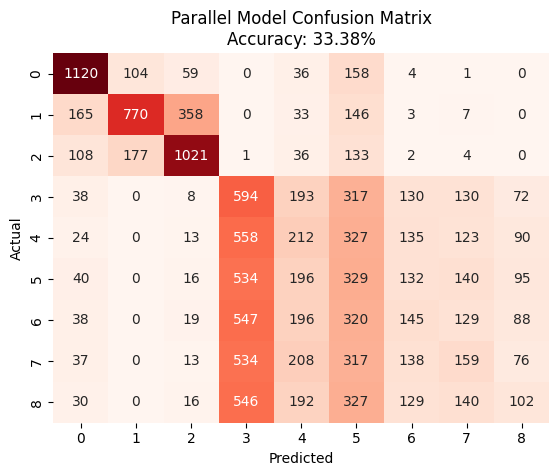

In [22]:
    cm_par = confusion_matrix(metrics['parallel']['final_true_labels'], 
                             metrics['parallel']['final_predictions'])
    sns.heatmap(cm_par, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title(f'Parallel Model Confusion Matrix\nAccuracy: {metrics["parallel"]["best_accuracy"]:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

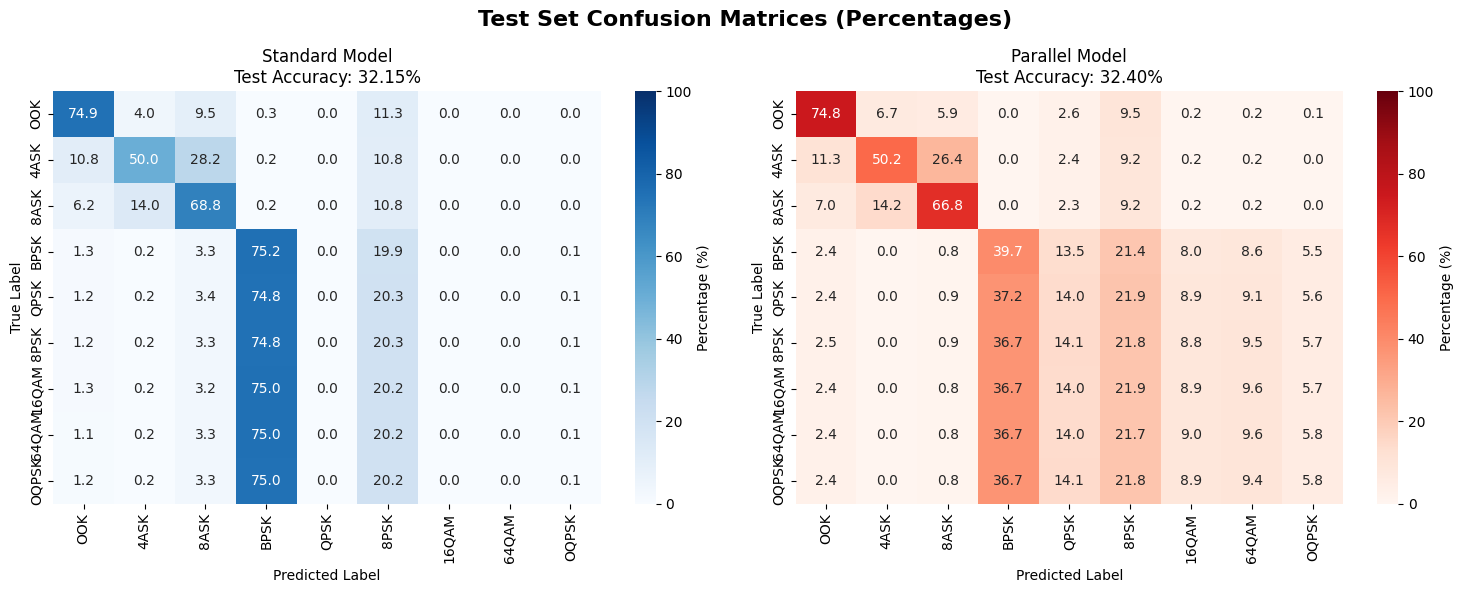

In [23]:
def plot_test_confusion_matrices_percentage(metrics, class_names=None):
    """
    Plot confusion matrices for test results with percentages
    """
    if 'test_predictions' not in metrics['standard'] or 'test_predictions' not in metrics['parallel']:
        print("❌ No test predictions found. Run final testing first!")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Test Set Confusion Matrices (Percentages)', fontsize=16, fontweight='bold')
    
    # Standard model confusion matrix
    cm_std = confusion_matrix(metrics['standard']['test_true_labels'], 
                             metrics['standard']['test_predictions'])
    # Convert to percentages (normalize by row)
    cm_std_pct = cm_std.astype('float') / cm_std.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm_std_pct, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=axes[0], cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
    axes[0].set_title(f'Standard Model\nTest Accuracy: {metrics["standard"]["test_accuracy"]:.2f}%')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Parallel model confusion matrix  
    cm_par = confusion_matrix(metrics['parallel']['test_true_labels'], 
                             metrics['parallel']['test_predictions'])
    # Convert to percentages (normalize by row)
    cm_par_pct = cm_par.astype('float') / cm_par.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm_par_pct, annot=True, fmt='.1f', cmap='Reds', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=axes[1], cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
    axes[1].set_title(f'Parallel Model\nTest Accuracy: {metrics["parallel"]["test_accuracy"]:.2f}%')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

plot_test_confusion_matrices_percentage(metrics, class_names=TARGET_MODULATIONS)

### **Heatmap Accuracy Over SNR level on Each Type Modulation**

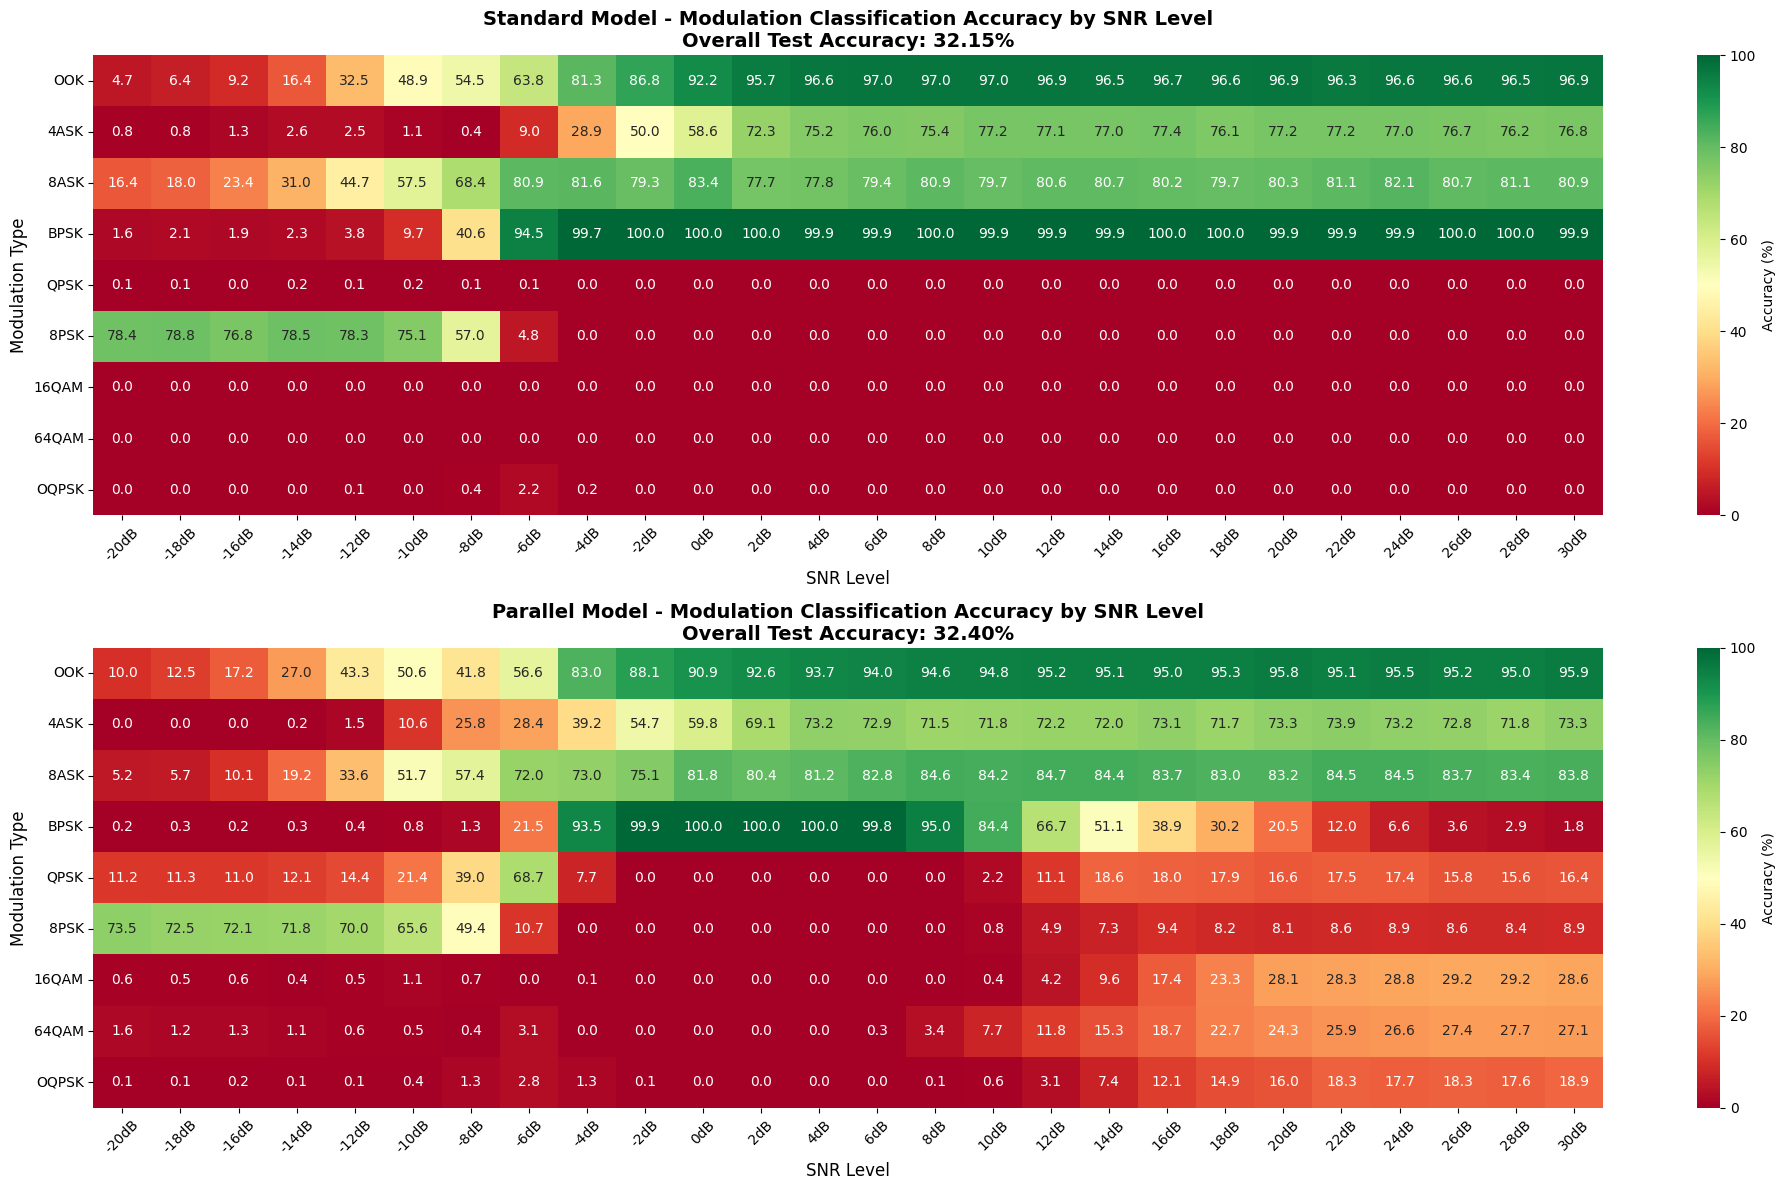

In [24]:
# --- Per-Modulation Accuracy Heatmap for 2 Models ---
def plot_modulation_snr_accuracy_heatmap_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    """
    Plot accuracy heatmaps comparing two models across modulations and SNR levels
    
    Args:
        model1, model2: PyTorch models to compare
        model1_name, model2_name: Names for the models
        dataloader: DataLoader containing test data
        device: Device to run inference on
        target_modulations: List of modulation names
    """
    
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    for idx, (model_name, model) in enumerate(models.items()):
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for batch in dataloader:
                # Handle different dataloader formats
                if len(batch) == 4:  # (i_inputs, q_inputs, labels, snrs)
                    i_inputs, q_inputs, labels, snrs = batch
                    i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                    labels = labels.to(device)
                    
                    # Combine I/Q inputs if model expects single input
                    if hasattr(model, 'forward'):
                        # Try to determine model input format
                        try:
                            outputs = model(i_inputs, q_inputs)  # Two separate inputs
                        except:
                            # Concatenate I and Q channels
                            combined_inputs = torch.cat([i_inputs.unsqueeze(1), q_inputs.unsqueeze(1)], dim=1)
                            outputs = model(combined_inputs)  # Single combined input
                    else:
                        combined_inputs = torch.cat([i_inputs.unsqueeze(1), q_inputs.unsqueeze(1)], dim=1)
                        outputs = model(combined_inputs)
                        
                elif len(batch) == 3:  # (data, labels, snrs)
                    data, labels, snrs = batch
                    data = data.to(device)
                    labels = labels.to(device)
                    outputs = model(data)
                    
                elif len(batch) == 2:  # (data, labels) - need to extract SNR from dataset
                    data, labels = batch
                    data = data.to(device)
                    labels = labels.to(device)
                    outputs = model(data)
                    # SNRs need to be extracted differently - this is a limitation
                    snrs = torch.zeros(len(labels))  # Placeholder - you'll need to modify this
                    print("⚠️ Warning: SNR information not available in dataloader")
                
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy() if hasattr(snrs, 'numpy') else snrs)
        
        # Create DataFrame for analysis
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        # Get unique SNR values and sort them
        unique_snrs = sorted(predictions_df['snr'].unique())
        accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
        
        # Calculate accuracy for each modulation at each SNR
        for i, mod in enumerate(target_modulations):
            for j, snr in enumerate(unique_snrs):
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracy_matrix[i, j] = accuracy * 100
                else:
                    accuracy_matrix[i, j] = 0  # No samples for this combination
        
        # Calculate overall accuracy for title
        overall_accuracy = (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        
        # Create heatmap for current model
        sns.heatmap(accuracy_matrix, 
                    xticklabels=[f'{int(snr)}dB' for snr in unique_snrs],
                    yticklabels=target_modulations,
                    annot=True, 
                    fmt='.1f', 
                    cmap='RdYlGn',
                    vmin=0, 
                    vmax=100,
                    cbar_kws={'label': 'Accuracy (%)'},
                    ax=axes[idx])
        
        axes[idx].set_title(f'{model_name} Model - Modulation Classification Accuracy by SNR Level\n'
                           f'Overall Test Accuracy: {overall_accuracy:.2f}%', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('SNR Level', fontsize=12)
        axes[idx].set_ylabel('Modulation Type', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_modulation_snr_accuracy_heatmap_comparison(
    model_standard, 
    model_parallel, 
    'Standard', 
    'Parallel', 
    test_loader, 
    device, 
    TARGET_MODULATIONS
)

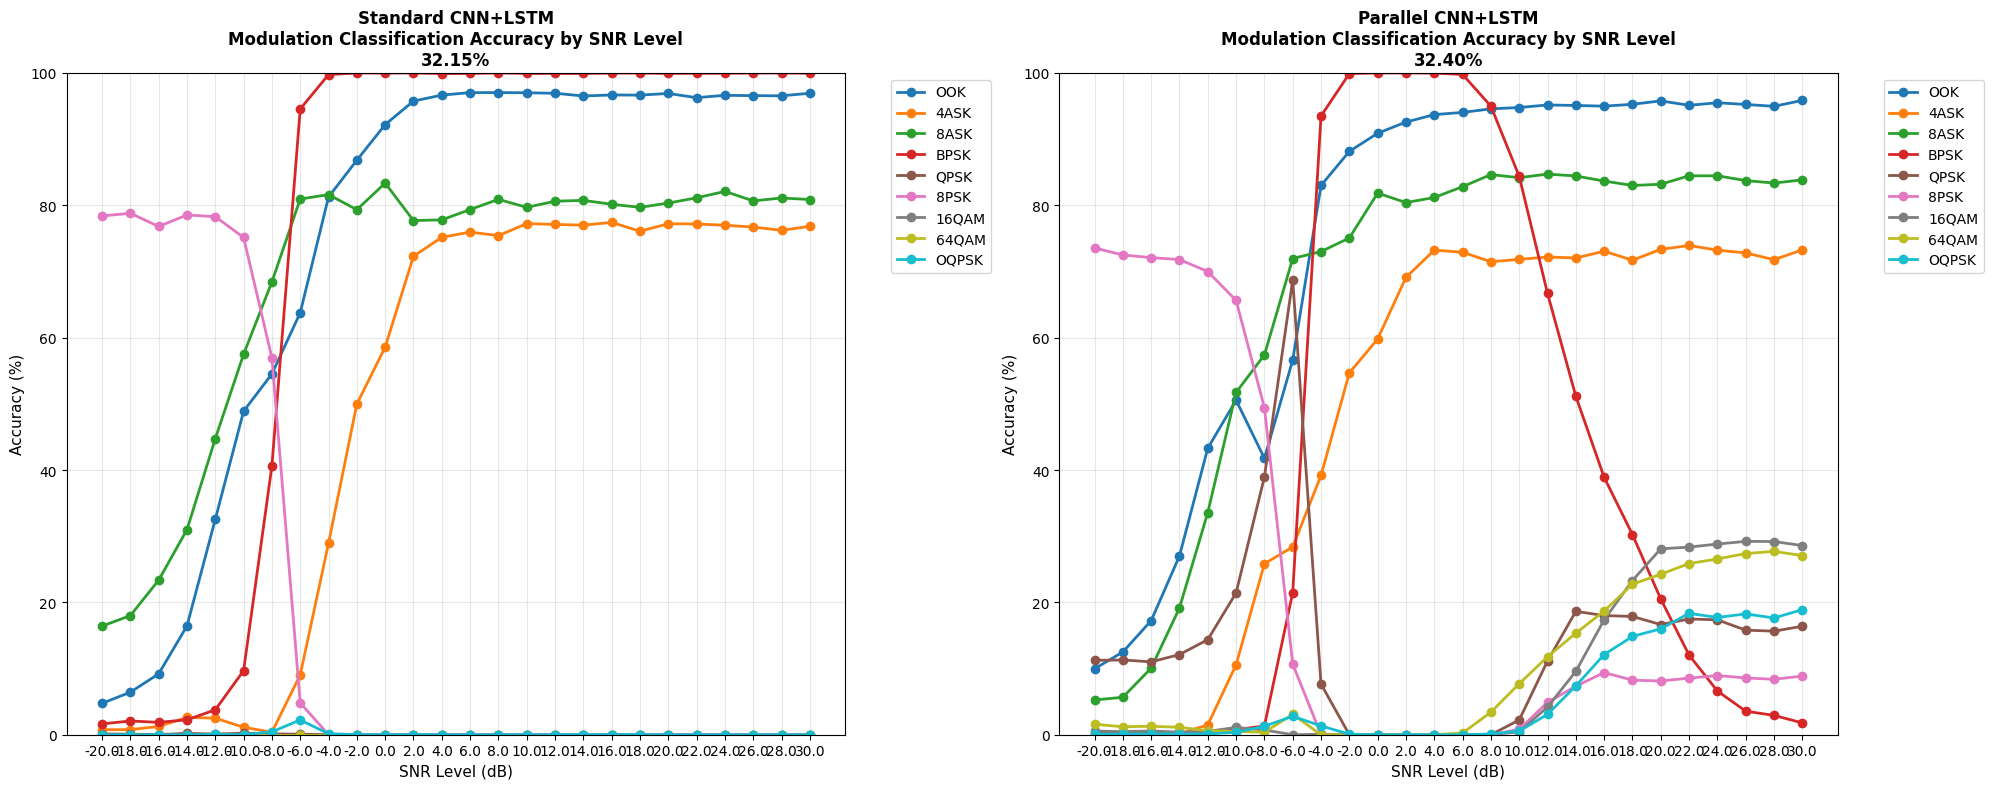

In [25]:
# --- Per-Modulation Accuracy Line Plot for 2 Models ---
def plot_modulation_snr_accuracy_lines_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Color palette for different modulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(target_modulations)))
    
    for idx, (model_name, model) in enumerate(models.items()):
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for i_inputs, q_inputs, labels, snrs in dataloader:
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(i_inputs, q_inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())
        
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        unique_snrs = sorted(predictions_df['snr'].unique())
        
        # Plot line for each modulation type
        for i, mod in enumerate(target_modulations):
            accuracies = []
            for snr in unique_snrs:
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracies.append(accuracy * 100)
                else:
                    accuracies.append(0)
            
            # Plot line for this modulation
            axes[idx].plot(unique_snrs, accuracies, 
                          marker='o', linewidth=2, markersize=6,
                          color=colors[i], label=mod)
        
        # Calculate overall accuracy for title
        overall_accuracy = (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        
        # Customize subplot
        axes[idx].set_title(f'{model_name} CNN+LSTM\nModulation Classification Accuracy by SNR Level\n{overall_accuracy:.2f}%', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('SNR Level (dB)', fontsize=11)
        axes[idx].set_ylabel('Accuracy (%)', fontsize=11)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[idx].set_ylim(0, 100)
        
        # Set x-axis ticks
        axes[idx].set_xticks(unique_snrs)
        axes[idx].set_xticklabels([f'{snr}' for snr in unique_snrs])
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_lines_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Alternative version: Overlay both models in single plot
def plot_modulation_snr_accuracy_lines_overlay(model1, model2, model1_name, model2_name, dataloader, device, target_modulations):
    
    models = {model1_name: model1, model2_name: model2}
    model_data = {}
    
    # Create single figure
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Color palette for different modulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(target_modulations)))
    
    # Process data for both models
    for model_name, model in models.items():
        model.eval()
        all_predictions = []
        all_true_labels = []
        all_snrs = []
        
        with torch.no_grad():
            for i_inputs, q_inputs, labels, snrs in dataloader:
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(i_inputs, q_inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_snrs.extend(snrs.numpy())
        
        predictions_df = pd.DataFrame({
            'true_label': all_true_labels,
            'predicted_label': all_predictions,
            'snr': all_snrs
        })
        
        model_data[model_name] = {
            'predictions_df': predictions_df,
            'overall_accuracy': (np.array(all_true_labels) == np.array(all_predictions)).mean() * 100
        }
    
    unique_snrs = sorted(model_data[model1_name]['predictions_df']['snr'].unique())
    
    # Plot lines for each modulation and model
    for i, mod in enumerate(target_modulations):
        for j, (model_name, data) in enumerate(model_data.items()):
            predictions_df = data['predictions_df']
            accuracies = []
            
            for snr in unique_snrs:
                subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
                if len(subset) > 0:
                    accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                    accuracies.append(accuracy * 100)
                else:
                    accuracies.append(0)
            
            # Different line styles for different models
            linestyle = '-' if j == 0 else '--'
            marker = 'o' if j == 0 else 's'
            
            # Plot line for this modulation and model
            ax.plot(unique_snrs, accuracies, 
                   marker=marker, linewidth=2, markersize=6,
                   color=colors[i], linestyle=linestyle,
                   label=f'{mod} ({model_name})')
    
    # Customize plot
    ax.set_title('Modulation Classification Accuracy by SNR Level\nComparison Between Models', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('SNR Level (dB)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 100)
    
    # Set x-axis ticks
    ax.set_xticks(unique_snrs)
    ax.set_xticklabels([f'{snr}' for snr in unique_snrs])
    
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_lines_overlay.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_modulation_snr_accuracy_lines_comparison(
    model_standard, 
    model_parallel, 
    'Standard', 
    'Parallel', 
    test_loader, 
    device, 
    TARGET_MODULATIONS
)

Extracting features from Standard model...
Extracting features from Parallel model...
Applying t-SNE...


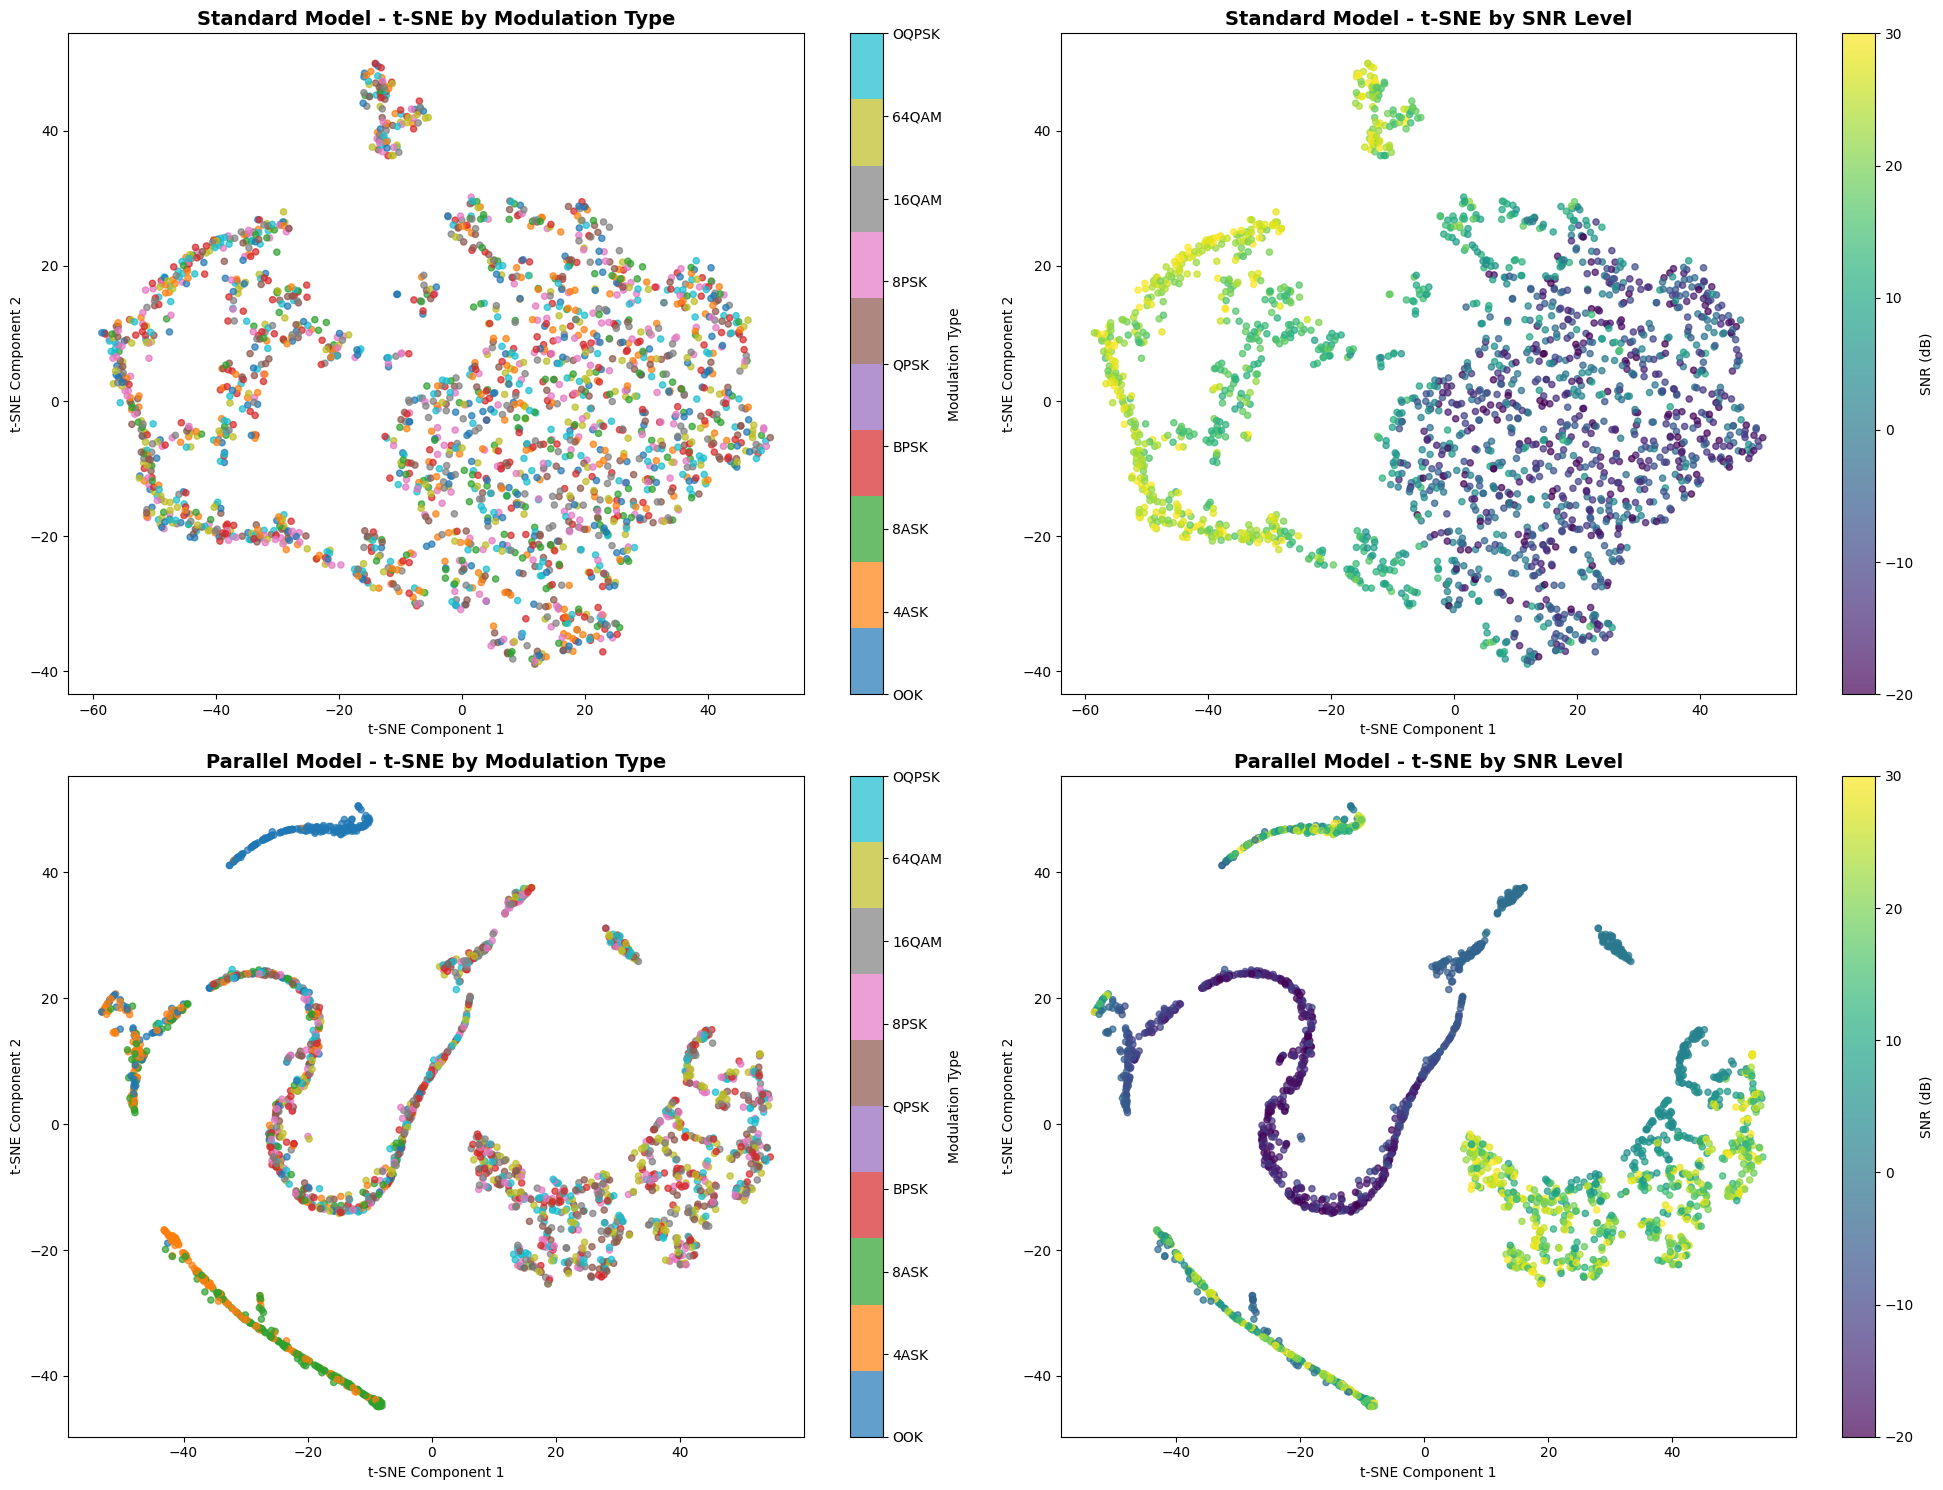

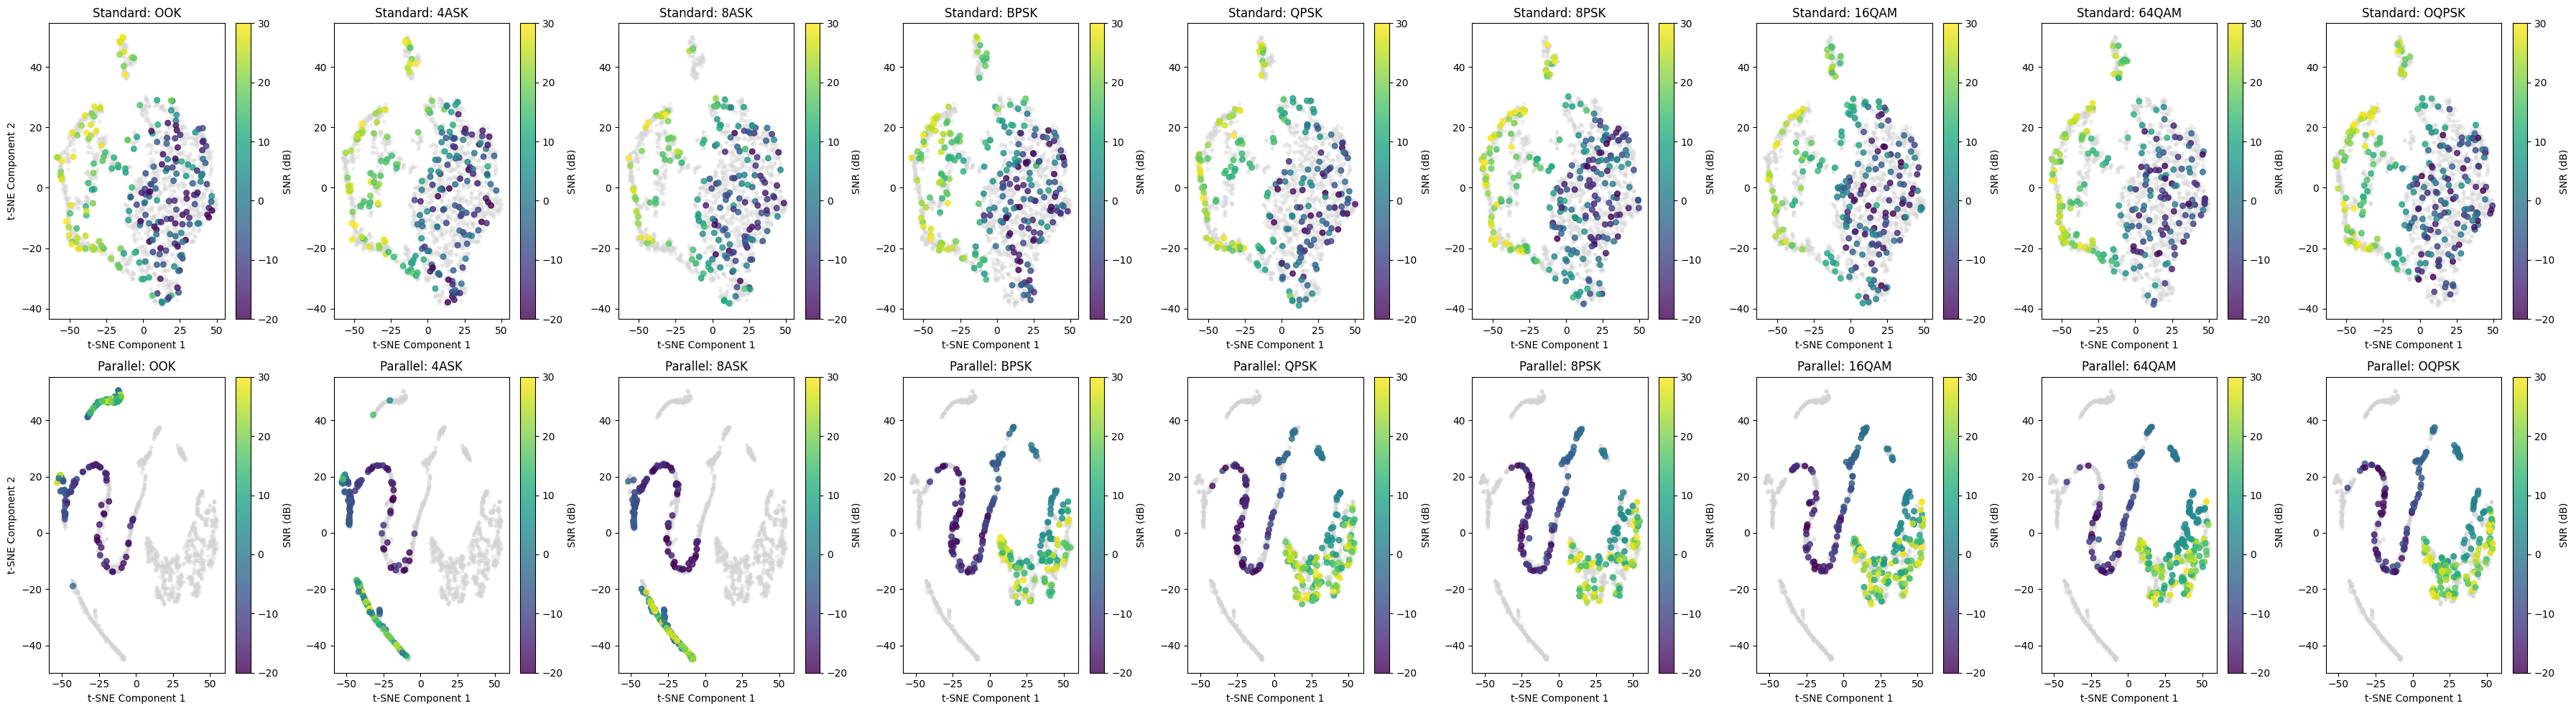

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def extract_features_from_model(model, dataloader, device, layer_name=None):
    """
    Extract features from a specific layer of the model
    
    Args:
        model: PyTorch model
        dataloader: DataLoader containing test data
        device: Device to run inference on
        layer_name: Name of layer to extract features from (if None, uses second-to-last layer)
    
    Returns:
        features: Extracted features
        labels: True labels
        snrs: SNR values
    """
    model.eval()
    features_list = []
    labels_list = []
    snrs_list = []
    
    # Hook to extract features
    def hook_fn(module, input, output):
        features_list.append(output.detach().cpu())
    
    # Register hook on the desired layer
    if layer_name:
        layer = dict(model.named_modules())[layer_name]
    else:
        # Get second-to-last layer (before final classification)
        modules = list(model.children())
        if len(modules) > 1:
            layer = modules[-2]  # Second-to-last layer
        else:
            # If model has sequential structure, get the layer before the last
            if hasattr(model, 'classifier'):
                layer = model.features if hasattr(model, 'features') else modules[-1]
            else:
                layer = modules[-1]
    
    hook = layer.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for batch in dataloader:
            # Handle different dataloader formats
            if len(batch) == 4:  # (i_inputs, q_inputs, labels, snrs)
                i_inputs, q_inputs, labels, snrs = batch
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                
                try:
                    _ = model(i_inputs, q_inputs)  # Two separate inputs
                except:
                    combined_inputs = torch.cat([i_inputs.unsqueeze(1), q_inputs.unsqueeze(1)], dim=1)
                    _ = model(combined_inputs)  # Single combined input
                    
            elif len(batch) == 3:  # (data, labels, snrs)
                data, labels, snrs = batch
                data = data.to(device)
                labels = labels.to(device)
                _ = model(data)
                
            elif len(batch) == 2:  # (data, labels)
                data, labels = batch
                data = data.to(device)
                labels = labels.to(device)
                _ = model(data)
                snrs = torch.zeros(len(labels))  # Placeholder
            
            labels_list.extend(labels.cpu().numpy())
            snrs_list.extend(snrs.numpy() if hasattr(snrs, 'numpy') else snrs)
    
    hook.remove()
    
    # Concatenate all features
    features = torch.cat(features_list, dim=0).numpy()
    
    # Flatten features if needed (for fully connected layers)
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
    
    return features, np.array(labels_list), np.array(snrs_list)

def plot_tsne_comparison(model1, model2, model1_name, model2_name, dataloader, device, target_modulations, n_samples=2000):
    """
    Create t-SNE visualization comparing feature representations of two models
    
    Args:
        model1, model2: PyTorch models to compare
        model1_name, model2_name: Names for the models
        dataloader: DataLoader containing test data
        device: Device to run inference on
        target_modulations: List of modulation names
        n_samples: Number of samples to use for t-SNE (for computational efficiency)
    """
    
    models = {model1_name: model1, model2_name: model2}
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Extract features from both models
    model_features = {}
    model_labels = {}
    model_snrs = {}
    
    for model_name, model in models.items():
        print(f"Extracting features from {model_name} model...")
        features, labels, snrs = extract_features_from_model(model, dataloader, device)
        
        # Subsample for computational efficiency
        if len(features) > n_samples:
            indices = np.random.choice(len(features), n_samples, replace=False)
            features = features[indices]
            labels = labels[indices]
            snrs = snrs[indices]
        
        model_features[model_name] = features
        model_labels[model_name] = labels
        model_snrs[model_name] = snrs
    
    # Apply t-SNE to each model's features
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    
    for idx, (model_name, features) in enumerate(model_features.items()):
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Apply t-SNE
        tsne_results = tsne.fit_transform(features_scaled)
        
        labels = model_labels[model_name]
        snrs = model_snrs[model_name]
        
        # Plot 1: Color by modulation type
        plt.subplot(2, 2, idx*2 + 1)
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                            c=labels, cmap='tab10', alpha=0.7, s=20)
        plt.title(f'{model_name} Model - t-SNE by Modulation Type', fontsize=14, fontweight='bold')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        
        # Add colorbar with modulation names
        cbar = plt.colorbar(scatter, ticks=range(len(target_modulations)))
        cbar.set_ticklabels(target_modulations)
        cbar.set_label('Modulation Type')
        
        # Plot 2: Color by SNR level
        plt.subplot(2, 2, idx*2 + 2)
        scatter_snr = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                                c=snrs, cmap='viridis', alpha=0.7, s=20)
        plt.title(f'{model_name} Model - t-SNE by SNR Level', fontsize=14, fontweight='bold')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        
        cbar_snr = plt.colorbar(scatter_snr)
        cbar_snr.set_label('SNR (dB)')
    
    plt.tight_layout()
    plt.savefig('tsne_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create detailed analysis plot
    create_detailed_tsne_analysis(model_features, model_labels, model_snrs, 
                                target_modulations, model1_name, model2_name)

def create_detailed_tsne_analysis(model_features, model_labels, model_snrs, 
                                target_modulations, model1_name, model2_name):
    """
    Create detailed t-SNE analysis with per-modulation separation
    """
    fig, axes = plt.subplots(2, len(target_modulations), figsize=(4*len(target_modulations), 10))
    
    # Apply t-SNE to each model separately
    model_tsne_results = {}
    
    for model_name, features in model_features.items():
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        model_tsne_results[model_name] = tsne.fit_transform(features_scaled)
    
    for model_idx, (model_name, tsne_results) in enumerate(model_tsne_results.items()):
        labels = model_labels[model_name]
        snrs = model_snrs[model_name]
        
        # Plot each modulation separately
        for mod_idx, modulation in enumerate(target_modulations):
            ax = axes[model_idx, mod_idx]
            
            # Highlight current modulation
            mask = labels == mod_idx
            other_mask = labels != mod_idx
            
            # Plot other modulations in gray
            ax.scatter(tsne_results[other_mask, 0], tsne_results[other_mask, 1], 
                      c='lightgray', alpha=0.3, s=10, label='Other')
            
            # Plot current modulation colored by SNR
            if np.sum(mask) > 0:
                scatter = ax.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                                   c=snrs[mask], cmap='viridis', alpha=0.8, s=30, 
                                   label=modulation)
                plt.colorbar(scatter, ax=ax, label='SNR (dB)')
            
            ax.set_title(f'{model_name}: {modulation}', fontsize=12)
            ax.set_xlabel('t-SNE Component 1')
            if mod_idx == 0:
                ax.set_ylabel('t-SNE Component 2')
    
    plt.tight_layout()
    plt.savefig('tsne_detailed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example:
plot_tsne_comparison(
    model_standard, 
    model_parallel, 
    'Standard', 
    'Parallel', 
    test_loader, 
    device, 
    TARGET_MODULATIONS,
    n_samples=2000  # Adjust based on your computational resources
)